#Strategy Overview

## Description of indicators used


####Chaikin Money Flow Index

The main indicator that our strategy is using is a volume indicator known as the Chaikin Money Flow Index. The Chaikin Money Flow is an indicator that is used to predict trend reversals.  The calculation involves use of the current volume and the current day’s high, low and close.  The concept of the On-Balance Volume indicator is: accumulation means people are buying the stock, while distribution implies people are selling the stock.

The calculation of the Chaikin Money Flow Index is shown below:

**CMF = n-day Sum of [(((C - L) - (H - C)) / (H - L)) x Vol] / n-day Sum of Vol**

where
- n = Number of periods (typically 21)
- H = High
- L = Low
- C = Close
- Vol = Volume

To see if today was accumulation or distribution, one would need to see if the price closed higher than it opened today.  Then, if the price has increased, it is accumulation, so add the volume to the cumulative sum.  If it has decreased, then it is distribution, so subtract from the cumulative sum.  

The Chaikin Money Flow is just a modified form of OBV, where instead of attributing the entire volume to accumulation or distribution, it adjusts the volume for how much closer the High/Low is to the closing price, then it adds the adjusted volume to the cumulative sum.


####Exponential Moving Averages

A second indicator is a short-term EMA and long-term EMA crossover.  The short-term EMA conveys a very short time trend, whereas the long-term EMA gives a longer time trend.  If the short-term EMA crosses over the long-term EMA, then this signifies a bullish price action signal.  This will complement the use of the CMF indicator, as the CMF uses volume and price, while the EMAs use primarily price action.

## Description of strategy

Our strategy is based on two conditions:

- long position if the short term price action is bullish (EMA1 > EMA2), and CMF value is above > 0

- short position if the short term price action is bearish (EMA1 <  EMA2) and CMF value is < 0

To put it concretely, 

**Buy/Long if EMA1 > EMA2 & CMF > 0**

**Sell/Short if EMA1 < EMA2 & CMF < 0**

where:
 - CMF  = Chaikin Money Flow
 - EMA1 = Short Exponential Moving Average
 - EMA2 = Long Exponential Moving Average

Because the EMA1 and EMA2s differ in length, the crossover is able to tell us if the short term trend is significant enough to deviate from the long term trend. The CMF acts as a confirmation with the price action signal to avoid false breakouts.

# Vectorised Backtesting

## Rule

**Buy/Long if EMA1 > EMA2 & CMF > 0**

**Sell/Short if EMA1 < EMA2 & CMF < 0**

## Variables

The 3 variables that we will be tuning are:
1. Lookback window for calculating Chaikin Money Flow Index
2. Short Term Exponential Moving Average Window
3. Long Term Exponential Moving Average Window

## Parameters

The lookback window size parameters are 20, 40.
The parameters for the short-term EMA  are 10, 25. 
The parameters for the long-term EMA are 50, 100.

A set parameter is the value of the CMF.  We used CMF > 0  to confirm bullish trends and CMF < 0 to confirm bearish trends.  This would be in line with technical analysis that the CMF uses volume and price to estimate buying or selling pressure.

The rules of the CMF are such that, if the CMF crosses above 0 and approaches 1, then it is a bullish trend.  If the CMF is below 0 and approaches -1, then it is a bearish trend.  Hence we decided to stick with using a negative value of CMF to confirm a potential short opportunity, and a positive value of CMF to confirm a potential long strategy.


## Strategy Implementation

###Imports

In [ ]:
!pip install yfinance
!pip install ta
!pip install gurobipy==9.5

from ta.utils import dropna
from ta.volatility import BollingerBands
from ta.trend import ADXIndicator
from ta.volatility import AverageTrueRange
from ta.trend import SMAIndicator
from ta.momentum import RSIIndicator
from ta.volume import VolumeWeightedAveragePrice
from ta.volume import ChaikinMoneyFlowIndicator
from ta.volume import chaikin_money_flow
from ta.trend import EMAIndicator
import matplotlib.pyplot as plt
import yfinance as yf
import math
import pandas as pd
import numpy as np

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.3 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for ta: filename=ta-0.10.2-py3-none-any.whl size=29106 sha256=16bf1877ed90b238a106d3e54d911c2e3ebd7c46528b4a3a78d874c2fdb18dd5
  Stored in directory: /root/.cache/pip/wheels/31/31/f1/f2ff471bbc5b84a4b973698ceecdd453ae043971791adc3431
Successfully built ta
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.5 MB 4.8 MB/s 


###Global constants

In [ ]:
TRAIN_START = "2010-01-01"
TRAIN_END = "2016-12-31"

TEST_START = "2016-01-01"
TEST_END = "2019-12-31"

INITIAL_CAPITAL = 500000

INTERVAL = "1d"

###Event based backtester

In [ ]:
class Common_Class():
  def __init__(self, symbol, start, end, interval, capital, transcation_cost, verbose = False):
    self.all_data ={}
    self.position = {}
    self.quantity = {}

    # init initial qty of all stocks to 0
    for stock in symbol:
      self.quantity['{}'.format(stock)] = 0

    self.symbol = symbol
    self.start = start
    self.end = end
    self.interval = interval
    self.initial_capital = capital
    self.capital = capital
    self.transaction_cost = transcation_cost
    self.trades = 0
    self.verbose = verbose
    # store detail of each trade
    self.stored_data = pd.DataFrame(columns = ['trade', 'date', 'position', 'price', 'symbol', 'quantity', 'capital'])

    # prepare data
    self.prepare_data()

  def prepare_data(self):
    '''
    retrieve required columns and calculate the returns of each stock
    '''
    for i in self.symbol:
      stock_data = yf.Ticker(i)
      hist_stock = stock_data.history(start = self.start, end = self.end, interval = self.interval)
      bt_data = pd.DataFrame()
      bt_data["Close_Price"] = hist_stock["Close"]
      bt_data["High"] = hist_stock["High"]
      bt_data["Low"] = hist_stock["Low"]
      bt_data["Volume"] = hist_stock["Volume"]
      bt_data["Return"] = np.log(bt_data["Close_Price"] / bt_data["Close_Price"].shift(1))
      bt_data = bt_data.dropna()
      self.all_data['{}'.format(i)] = bt_data


  def close_graph(self, stock):
    i = str(stock)
    plt.figure(figsize=(15, 5))
    plt.plot(self.all_data[i]["Close_Price"] ,color='black', label='Price', linestyle='dashed')
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.title("Close Prices of {}".format(i))
    plt.legend()
    plt.grid()
    plt.show()

  def return_date_price(self, bar, stock):
    '''
    return date and price of a stock for the specifc bar
    '''
    stock_str = str(stock)
    # get the bar-th date
    date = str(self.all_data[stock_str].index[bar])[:10]
    # get the bar-th close price
    price = self.all_data[stock_str].Close_Price.iloc[bar]

    return date, price

  def realised_balance(self, bar):
    '''
    cal the realized balance for the bar-th date which is stored in self.capital
    since capital is combination of all stock so can use any stock to get the capital
    '''
    date, price = self.return_date_price(bar, self.symbol[0])

    if self.verbose:
      print("Date :{} | Realised Balance: {:0.1f}".format(date, self.capital))

    return self.capital

  def unrealised_balance(self, bar):
    '''
    cal the unrealized capital which is determined by the postions that are currently holding at bar-th date
    '''
    ub = 0
    for stock in self.symbol:
      # retrieve the date and stock close price for the bar-th date
      date, price = self.return_date_price(bar, stock)
      # calc blance by just using stock qty * price
      ub =  ub + self.quantity['{}'.format(stock)] * price

    if self.verbose:
      print("Date :{} | Unrealised Balance: {:0.1f}".format(date,ub))

    return ub

  def total_balance(self, bar):
    '''
    unrealized plus realized
    '''
    return self.unrealised_balance(bar) + self.realised_balance(bar)
  
  def total_capital(self):
    return self.capital

  def store_results(self, trade, date, position, price, symbol, quantity, capital):
    trade_detail = pd.DataFrame({
        'trade':pd.Series(trade), 
        'date':pd.Series(date), 
        'position':pd.Series(position), 
        'price':pd.Series(price), 
        'symbol':pd.Series(symbol), 
        'quantity':pd.Series(quantity), 
        'capital':pd.Series(capital) })
    
    self.stored_data = pd.concat([self.stored_data, trade_detail])

  def performance_plots(self):
    '''
    performance based on dataframe of daily account balances
    '''
    Final_result_data = self.Final_result_data #saving time to write self everywhere
    interval = str(self.interval)
    f, ax = plt.subplots(2,3,figsize=(20,10))

    #plot 1: Close Price os stock
    plt.subplot(2, 3, 1)
    for stock in self.symbol:
      plt.plot(Final_result_data['Returns_{}'.format(stock)].cumsum(), label='{}'.format(stock), linestyle='dashed')
    plt.title("Cum Log returns of included stocks")
    plt.xlabel(interval)
    plt.legend()
    plt.grid()

    #plot 2: Histogram of dtrstegy returns
    plt.subplot(2, 3, 2)
    plt.hist(Final_result_data['capital_log_returns'], bins = 35, label='Strategy Returns', linestyle='dashed')
    plt.title("Histogram of Strategy returns")
    plt.xlabel(interval)
    plt.legend()
    plt.grid()

    #plot 3: Strategy vs Instrument
    plt.subplot(2, 3, 3)
    plt.plot(Final_result_data['Total_Stock_Returns_cum_sum'],color='red', label='Equal weighted stock Returns', linestyle='dashed')
    plt.plot(Final_result_data['capital_returns_log_cum_sum'].dropna(), label ='Strategy Returns')
    plt.title("Strategy Vs Stock Cum Return Curve")
    plt.xlabel(interval)
    plt.legend()
    plt.grid()

    #plot 4: Drawdown
    plt.subplot(2, 3, 4)
    plt.plot(Final_result_data["capital_returns_log_cum_sum"].dropna(), label='Cum log returns')
    plt.plot(Final_result_data["Cum_Max"].dropna(), label =  'Max Drawdown')
    plt.title("Drawdown")
    plt.xlabel(interval)
    plt.legend()
    plt.grid()

    #plot 5: Equity Curve
    plt.subplot(2, 3,  5)
    plt.plot(Final_result_data["capital"].dropna(), label =  'Equity $')
    plt.title("Equity Curve")
    plt.xlabel(interval)
    plt.legend()
    plt.grid()

    plt.suptitle("Performance Plots")
    f.delaxes(ax[1,2]) # to delete the last subplot

    plt.show()

  def performance(self):
    '''
    stored_data has [trade, date, position, price, symbol, quantity, capital]
    B = self.stored_data -> this will have many rows ; n(number of instruments) times more
    C = self.all_data -> will need this to aggregate the returns from all stocks
    B.index = range(B.shape[0]/len(self.symbol))

    Since the stocks are not stored in arranged manner, we need to arrange them so that we can get the entry price and exit price for each day
    stored data has many rows, we will aggregate day wise
    '''
    # creating a new datframe to store aggregated values
    df = pd.DataFrame()

    df['capital'] = self.stored_data.groupby('date').agg({'capital': 'mean'})
    #df.index = range(self.stored_data.shape[0]/len(self.symbol)) # shape[0] to get the length of rows of each stock and make an index for dataframe df

    trade_start_date = df['capital'].index[0] # If intraday, then index needs to be adjusted with time, for daily, its fine
    trade_end_date = df['capital'].index[-1] # This will work when interval is 1D

    #Also, since we have multiple stocks, we need to calculate expected returns to comapre against the strategy

    for stock in self.symbol:
      A = (self.all_data[stock][trade_start_date:trade_end_date]['Return'].tolist()) # The returns are already log
      df['Returns_{}'.format(stock)] = A

    c = df.columns #fetch all the columns of datframe
    df['Total_Stock_Returns'] = (df.loc[:,c[-len(self.symbol):]].sum(1))/len(self.symbol) # Sums up last N columns of df and divvide by number of stocks. Equal weightage
    df['Total_Stock_Returns_cum_sum'] = df['Total_Stock_Returns'].cumsum()
    df.index = range(df.shape[0])

    df['capital_after_settlement'] = df['capital'].shift(-1)

    # Since we are are utilising capital, we will calculate returns for SR based on daily capital/equity changes
    # Remember, you can change the returns on investment based on the capital you trade

    df['capital_regular_returns'] = (df['capital_after_settlement']/df['capital'] - 1)
    df['capital_log_returns'] = np.log(df['capital_after_settlement']/df['capital'])
    df["capital_returns_log_cum_sum"] = df["capital_log_returns"].cumsum()

    # for drawdown calculation
    df["Cum_Max"] = df["capital_returns_log_cum_sum"].cummax()
    df["drawdown"] = df["Cum_Max"] - df["capital_returns_log_cum_sum"]

    df.drop(df.index[df['capital_log_returns'] == 0.0], inplace=True) #Dropping the last column, as I already got the values through shift(1)
    df = df.dropna()

    '''
    #arranging the columns for better readeability
    cols =['trade','symbol','position','quantity','date', 'exit_date', 'price','exit_price',\
           'price_log_returns','price_log_returns_cum_sum','capital',\
          'capital_after_settlement', 'capital_regular_returns', 'capital_log_returns',\
           'capital_returns_log_cum_sum','Cum_Max','drawdown']
    B = B[cols]
    B.rename(columns = {'date':'entry_date', 'price':'entry_price'}, inplace = True)

    '''

    #storing the results in Final_result data
    Final_result_data = df
    #Final_result_data.head()

    #Plot the equity curve
    # plt.plot(Final_result_data['exit_date'],Final_result_data['capital_after_settlement'])
    # Final_result_data[['exit_date', 'capital_after_settlement']].dropna().plot(figsize =(15,6), title = "Equity /Capital Plot")

    print("=" *50)
    print("Performance Metrics")

    #Total Balance
    print("The total capital at end of strategy: {:0.1f}".format(self.capital))

    # Annual gross expected returns
    daily_log_mean_ret = Final_result_data['capital_log_returns'].mean()
    annual_log_ret = 252 * daily_log_mean_ret
    annual_regular_return = (np.exp(annual_log_ret) -1)*100
    print("The annual regular returns: {:0.2f} %".format(annual_regular_return))

    # Annual std deviation
    daily_regular_std = (np.exp(Final_result_data['capital_log_returns'])-1).std()
    annual_regular_std =  daily_regular_std * (252 **0.5) *100
    print("The annual regular std deviation: {:0.2f} %".format(annual_regular_std))

    #Annual Sharpe Ratio
    SR = annual_regular_return / annual_regular_std
    print("The annual Sharpe Ratio: {:0.2f}".format(SR))

    #The strategy returns on investment in percent

    #Total_Log_ret = Final_result_data['capital_log_returns'].sum()
    #Total_Log_ret
    #Regular_ROI = (np.exp(Total_Log_ret) - 1) *100
    #print("The returns on investment from {} to {} by this strategy is {:0.2f} %".format(self.start, self.end, Regular_ROI))

    # the above method will also produce same result

    returns = (self.capital - self.initial_capital) /self.initial_capital *100
    print("The returns on investment from {} to {} by this strategy is {:0.1f} %".format(self.start, self.end, returns))

    #Calculate Drawdown
    #Final_result_data[["capital_returns_log_cum_sum", "Cum_Max"]].dropna().plot(figsize =(15,6), title = "Drawdown Plot")

    Drawdown = Final_result_data["drawdown"].max()*100
    print("The maximum drawdown: {:.2f} %".format(Drawdown))

    zero_periods = Final_result_data[Final_result_data['drawdown'] == 0]
    delta_values = (zero_periods.index[1:] - zero_periods.index[:-1])
    print("The maximum drawdown period: {:.2f} days".format(delta_values.max()))

    #Annual Sortino Ratio
    only_neg_log_returns = Final_result_data[Final_result_data['capital_log_returns']<0]['capital_log_returns']
    only_neg_regular_returns = np.exp(only_neg_log_returns)-1

    daily_std_dev_for_sortino = only_neg_regular_returns.std()
    annual_std_dev_for_sortino = daily_std_dev_for_sortino * (252 ** 0.5)*100

    sortino = annual_regular_return / annual_std_dev_for_sortino
    print("The annual Sortino Ratio: {:0.2f}".format(sortino))

    #Total trades
    print("The total trades taken by the strategy: {}".format(self.trades))


    print("=" *50)

    self.Final_result_data = Final_result_data
    #print(self.Final_result_data.head())


  def buy_order(self,bar,stock,quantity=None, dollar =None ):
    date, price = self.return_date_price(bar, stock)

    if quantity == None:
      quantity = int(dollar/price)

    self.capital = self.capital - ((quantity * price)*(1 + self.transaction_cost)) # capital will be lost in buying
    self.quantity['{}'.format(stock)] = self.quantity['{}'.format(stock)] + quantity
    self.trades = self.trades + 1
    self.position['{}'.format(stock)] += 1
    # to store the total balance due to all the stocks at the end of the day, so that I get 1 value at the EOD
    tb = self.total_balance(bar)
    #self.quantity['{}'.format(stock)]*price + self.capital # this is just for one stock, however, I need for all the stocks
    self.store_results(self.trades, date, self.position['{}'.format(stock)], price, stock, quantity, tb)

    if self.verbose:
      print("Bought {} shares of {} at {:0.1f} per share worth {:0.1f} $".format(quantity,stock, price, quantity * price))
      print('Total quantity for {} is {}'.format(stock,self.quantity['{}'.format(stock)]))


  def sell_order(self,bar,stock, quantity=None, dollar=None ):
    date, price = self.return_date_price(bar, stock)

    if quantity == None:
      quantity = int(dollar/price)

    self.capital = self.capital + ((quantity * price)*(1 - self.transaction_cost)) # capital will be added after selling
    self.quantity['{}'.format(stock)] = self.quantity['{}'.format(stock)] - quantity
    self.trades = self.trades + 1
    self.position['{}'.format(stock)] -= 1
    # to store the total balance due to all the stocks at the end of the day, so that I get 1 value at the EOD
    tb = self.total_balance(bar)
    self.store_results(self.trades, date, self.position['{}'.format(stock)], price, stock, quantity, tb)

    if self.verbose:
      print("Sold {} shares of {} at {:0.1f} per share worth {:0.1f} $".format(quantity,stock, price, quantity * price))
      print('Total quantity for {} is {}'.format(stock,self.quantity['{}'.format(stock)]))

  def last_trade(self, bar):# this needs to be check for all open positions of all stocks

    for stock in self.symbol:
      date, price = self.return_date_price(bar, stock)
      last_quantity = self.quantity['{}'.format(stock)]
      self.capital = self.capital + last_quantity * price
      # junhao's edit
      # self.capital = self.capital + self.stock_quantity[symbol] * price
      self.quantity['{}'.format(stock)] = 0 # as no more quantity now. all will be settled
      self.trades = self.trades +1

      if self.position['{}'.format(stock)] == -1: # if closing out a short position
        last_quantity = - last_quantity # to keep a pos number in records. Note, self.quantity is always maintianing a +/- sign.
        self.position['{}'.format(stock)] = 1 # to record we are buying to close out
      else:
        last_quantity =  last_quantity # to keep a positve nymber in records
        self.position['{}'.format(stock)] = -1 # to record we are selling to close out

      #self.position = 0
      tb = self.total_balance(bar)
      self.store_results(self.trades, date, self.position['{}'.format(stock)], price, stock, last_quantity, tb)

      if self.verbose:
        print("Closed open trades for {} shares of {} at {:0.1f} per share worth {:0.1f} $".format(last_quantity,stock, price, last_quantity * price))


### Strategy Class

In [ ]:
class ChaikinMFIWithEMAStrategy(Common_Class):

  def go_long(self, bar, stock, quantity = None, dollar = None):
    # clear prev short pos first
    self.close_position(bar, stock)
    
    if quantity:
      self.buy_order (bar, stock, quantity = quantity) # to create new fresh order
    elif dollar:
      if dollar == 'all':
        dollar = self.capital

      self.buy_order(bar, stock, dollar = dollar)

  def go_short(self, bar, stock, quantity = None, dollar = None):
    # clear prev long pos first
    self.close_position(bar, stock)
    
    if quantity:
      self.sell_order (bar, stock, quantity = quantity)
    elif dollar:
      if dollar == 'all':
        dollar = self.capital

      self.sell_order(bar, stock, dollar = dollar)
    
  def close_position(self, bar, stock):
    self.position['{}'.format(stock)] = 0

    if self.position['{}'.format(stock)] == -1: # close short
      self.buy_order(bar,stock, quantity = - self.quantity['{}'.format(stock)])
    elif self.position['{}'.format(stock)] == 1: # close long
      self.sell_order(bar,stock, quantity = self.quantity['{}'.format(stock)])

  def check_stoploss(self, bar, stock):
    if self.position['{}'.format(stock)] == -1: # currently in a short
      date_of_position_entering = self.stored_data[self.stored_data["symbol"] == stock].iloc[-1]["date"]
      stock_data = self.all_data[stock]
      cum_min_price = stock_data[stock_data.index >= date_of_position_entering]["Close_Price"].min()
      stop_loss_price = cum_min_price*1.05
      if self.return_date_price(bar, stock)[1] > stop_loss_price:
        # print(f"STOPLOSS FOR SHORT, {bar}")
        self.close_position(bar,stock)
    
    elif self.position['{}'.format(stock)] == 1: # currently in a long
      # if we cross the stoploss limit, 99% of the cum max
      date_of_position_entering = self.stored_data[self.stored_data["symbol"] == stock].iloc[-1]["date"]
      stock_data = self.all_data[stock]
      cum_max_price = stock_data[stock_data.index >= date_of_position_entering]["Close_Price"].max()
      stop_loss_price = cum_max_price*0.95
      
      # close the position once we hit the stop loss limit
      if self.return_date_price(bar, stock)[1] < stop_loss_price:
        # print(f"STOPLOSS FOR LONG, {bar}")
        self.close_position(bar,stock)

  def run_strategy(self, LookbackWindow, STWindow, LTWindow):
    self.stop = False 
    self.trades = 0
    self.capital = self.initial_capital

    # preparing data with required indicators
    for stock in self.symbol:
      self.quantity['{}'.format(stock)] = 0
      self.position['{}'.format(stock)] = 0

      ChaikinMFI = ChaikinMoneyFlowIndicator(
          high = self.all_data['{}'.format(stock)]["High"], 
          low = self.all_data['{}'.format(stock)]["Low"], 
          close = self.all_data['{}'.format(stock)]["Close_Price"],
          volume = self.all_data['{}'.format(stock)]["Volume"], 
          window= LookbackWindow).chaikin_money_flow()
      STEMA = EMAIndicator(self.all_data['{}'.format(stock)]["Close_Price"], STWindow).ema_indicator()
      LTEMA = EMAIndicator(self.all_data['{}'.format(stock)]["Close_Price"], LTWindow).ema_indicator()

      self.all_data['{}'.format(stock)]['ChaikinMFI_{}'.format(stock)] = ChaikinMFI
      self.all_data['{}'.format(stock)]['STEMA_{}'.format(stock)] = STEMA
      self.all_data['{}'.format(stock)]['LTEMA_{}'.format(stock)] = LTEMA

    # from the available data bar to the last data bar  
    for bar in range(LTWindow, len(self.all_data['{}'.format(self.symbol[0])])): 
      #Making a func so that no trade if balance goes below 0

      tb = self.total_balance(bar)
      if tb < 0:
        print("!" * 50)
        print("negative capital")
        print("!" * 50)
        self.last_trade(bar)
        self.stop = True
        break

      for stock in self.symbol:
        date, price = self.return_date_price(bar, stock)
        L = [self.all_data['{}'.format(stock)]['Close_Price'].iloc[bar_val] for bar_val in range(bar-5, bar+1)]

        # go long if CMFI >= 0 and STEMA > LTEMA
        if self.all_data['{}'.format(stock)]['ChaikinMFI_{}'.format(stock)].iloc[bar] >= 0 and \
           self.all_data['{}'.format(stock)]['STEMA_{}'.format(stock)].iloc[bar] > self.all_data['{}'.format(stock)]['LTEMA_{}'.format(stock)].iloc[bar] and \
           all(x<=y for x, y in zip(L, L[1:])):
           
           # if we are not yet in a long position
           if self.position['{}'.format(stock)] == -1 or self.position['{}'.format(stock)] == 0:
            # for now, assign equal weight, can further tune this weight
            self.go_long(bar, stock, dollar = self.capital/len(self.symbol))

            # check stop loss/take profit
           else:
            self.check_stoploss(bar, stock)
           

        # go short if CMFI <= 0 and STEMA < LTEMA
        elif self.all_data['{}'.format(stock)]['ChaikinMFI_{}'.format(stock)].iloc[bar] <= 0 and \
           self.all_data['{}'.format(stock)]['STEMA_{}'.format(stock)].iloc[bar] < self.all_data['{}'.format(stock)]['LTEMA_{}'.format(stock)].iloc[bar] and \
           all(x>=y for x, y in zip(L, L[1:])):
           
           # if we are not yet in a short position
           if self.position['{}'.format(stock)] == 1 or self.position['{}'.format(stock)] == 0:
            # for now, assign equal weight, can further tune this weight
            self.go_short(bar, stock, dollar = self.capital/len(self.symbol)) 
            
           # check stop loss/take profit
           else:
            self.check_stoploss(bar, stock)

        # close position if above rule not met
        else:
          self.close_position(bar, stock)

        #-----Storing all the values for calculating Sharpe----- # TODO: to get back to
        store_quantity = abs(self.quantity['{}'.format(stock)]) # so that I want just the positive numbers in my performance table. I will calculate +/- based on position sign
        tb = self.total_balance(bar)
        self.store_results(0, date, self.position['{}'.format(stock)], price, stock, store_quantity, tb)

    # to make sure not to run this func 2 times when early exit due to negative balance
    if self.stop == False:
      self.last_trade(bar)

###Portfolio selection

We will be creating the portfolio using a group of Dow Jones stocks (30 stocks). We generate the efficient frontier from the 30 stocks.

In [ ]:
symbols_list = [
"AXP",
"AMGN",
"AAPL",
"BA",
"CAT",
"CSCO",
"CVX",
"GS",
"HD",
"HON",
"IBM",
"INTC",
"JNJ",
"KO",
"JPM",
"MCD",
"MMM",
"MRK",
"MSFT",
"NKE",
"PG",
"TRV",
"UNH",
"CRM",
"VZ",
"V",
"WBA",
"WMT",
"DIS",
# "DOW"
]

data = yf.download(symbols_list, start=TRAIN_START, end=TRAIN_END, interval=INTERVAL)

closes = np.transpose(np.array(data.Close)) # matrix of daily closing prices
absdiff = np.diff(closes)                   # change in closing price each day
reldiff = np.divide(absdiff, closes[:,:-1]) # relative change in daily closing price
delta = np.mean(reldiff, axis=1)            # mean price change
sigma = np.cov(reldiff)                     # covariance (standard deviations)
std = np.std(reldiff, axis=1)               # standard deviation

[*********************100%***********************]  29 of 29 completed


In [ ]:
import gurobipy as gp
from gurobipy import GRB
from math import sqrt

# Create an empty model
m = gp.Model('portfolio')

# Add matrix variable for the stocks
x = m.addMVar(len(symbols_list))

# Objective is to minimize risk (squared).  This is modeled using the
# covariance matrix, which measures the historical correlation between stocks

portfolio_risk = x @ sigma @ x
print(portfolio_risk)

m.setObjective(portfolio_risk, GRB.MINIMIZE)

# Fix budget with a constraint
m.addConstr(x.sum() == 1, 'budget')

# Verify model formulation
m.write('portfolio_selection_optimization.lp')

# Optimize model to find the minimum risk portfolio
m.optimize()

Restricted license - for non-production use only - expires 2023-10-25
<gurobi.MQuadExpr:
Q:
  (0, 0)	0.0002728330242962487
  (0, 1)	7.142710196370582e-05
  (0, 2)	9.024291095524232e-05
  (0, 3)	9.776121537483219e-05
  (0, 4)	0.00011951757342161416
  (0, 5)	0.00012557727234756153
  (0, 6)	9.874813224238451e-05
  (0, 7)	8.148243661346555e-05
  (0, 8)	8.331783636493231e-05
  (0, 9)	9.743796314271589e-05
  (0, 10)	7.736652051473628e-05
  (0, 11)	0.00010053513164515491
  (0, 12)	7.672252425444743e-05
  (0, 13)	9.513457713313551e-05
  (0, 14)	4.581392464338661e-05
  (0, 15)	0.00010037203026838595
  (0, 16)	4.550120682203227e-05
  (0, 17)	5.101952150157812e-05
  (0, 18)	7.919842201585604e-05
  (0, 19)	5.693908397464352e-05
  (0, 20)	9.406172973687236e-05
  (0, 21)	8.11937387617065e-05
  (0, 22)	4.270291402905064e-05
  (0, 23)	6.051907339860033e-05
  (0, 24)	7.74493953433882e-05
  :	:
  (28, 4)	5.013261038206596e-05
  (28, 5)	4.659914963008975e-05
  (28, 6)	5.115538410245645e-05
  (28, 7)	4.44

In [ ]:
minrisk_volatility = sqrt(m.ObjVal)
minrisk_return = delta @ x.X
pd.DataFrame(data=np.append(x.X, [minrisk_volatility, minrisk_return]),
             index=symbols_list + ['Volatility', 'Expected Return'],
             columns=['Minimum Risk Portfolio'])


,Minimum Risk Portfolio
AXP,1.367544e-02
AMGN,5.688088e-08
AAPL,5.452509e-08
BA,2.356500e-08
CAT,1.742462e-08
CSCO,1.603184e-08
CVX,3.919123e-08
GS,3.042524e-08
HD,4.207287e-08
HON,5.053818e-08


In [ ]:
# Create an expression representing the expected return for the portfolio
portfolio_return = delta @ x
target = m.addConstr(portfolio_return == minrisk_return, 'target')

# Solve for efficient frontier by varying target return
frontier = np.empty((2,0))
for r in np.linspace(delta.min(), delta.max(), 25):
    target[0].rhs = r
    m.optimize()
    frontier = np.append(frontier, [[sqrt(m.ObjVal)],[r]], axis=1)

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (linux64)
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads
Optimize a model with 2 rows, 29 columns and 58 nonzeros
Model fingerprint: 0xdfa15674
Model has 435 quadratic objective terms
Coefficient statistics:
  Matrix range     [2e-04, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [1e-04, 1e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 1e+00]
Presolve time: 0.02s
Presolved: 2 rows, 29 columns, 58 nonzeros
Presolved model has 435 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 28
 AA' NZ     : 4.350e+02
 Factor NZ  : 4.650e+02
 Factor Ops : 9.455e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.37769002e+05 -1.37769002e+05  2.80e+04 1.10e-03  1.00e+06     0s
   1   3.74411409e+03 -3.77267729e+03  9.54e+02 3

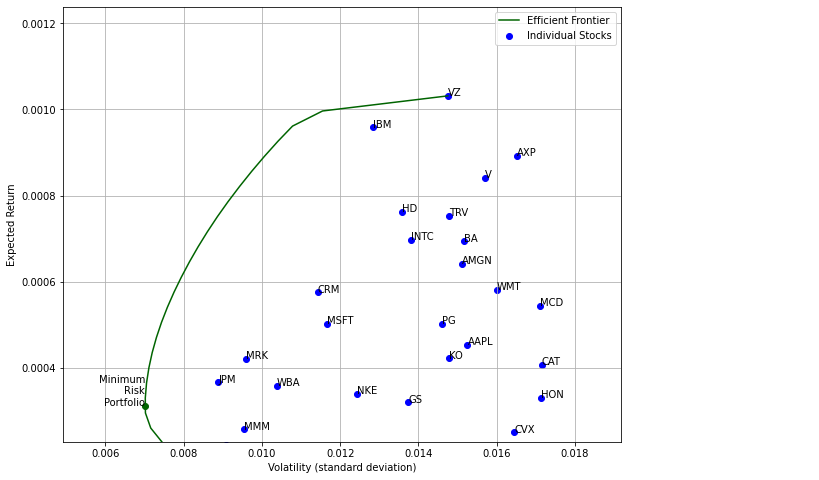

In [ ]:
#plt.figure(figsize=(10,10))

fig, ax = plt.subplots(figsize=(10,8))

# Plot volatility versus expected return for individual stocks
ax.scatter(x=std, y=delta,
           color='Blue', label='Individual Stocks')

for i, stock in enumerate(symbols_list):
    ax.annotate(stock, (std[i], delta[i]))

# Plot volatility versus expected return for minimum risk portfolio
ax.scatter(x=minrisk_volatility, y=minrisk_return, color='DarkGreen')
ax.annotate('Minimum\nRisk\nPortfolio', (minrisk_volatility, minrisk_return),
            horizontalalignment='right')

# Plot efficient frontier
ax.plot(frontier[0], frontier[1], label='Efficient Frontier', color='DarkGreen')

# Format and display the final plot
ax.axis([frontier[0].min()*0.7, frontier[0].max()*1.3, delta.min()*1.2, delta.max()*1.2])
ax.set_xlabel('Volatility (standard deviation)')
ax.set_ylabel('Expected Return')
ax.legend()
ax.grid()
plt.show()

## Parameters

We will define the range of parameters that we will train using all available data from "2010-01-01" to "2016-12-31".

In [ ]:
# ChaikinMFI Thresholds
LookbackWindow = [20, 40]

# STWindow
STWindow = [10, 25]

# LTWindow
LTWindow = [50, 100]

Based on the efficient frontier plotted above, we select the stocks that are closest to the frontier. The stocks chosen have various volatility and returns, thius diversifying our portfolio.

In [ ]:
tickers = ["VZ", "IBM", "CRM", "MRK", "JPM"]

## Out of sample backtesting

### Grid Search

We will perform a grid search on our defined parameters.

In each combination, we will calculate the returns of the strategy of the selected stocks across the periods from 2010 to 2016, which is the training period.

To determine the optimal combination of parameters, we will use the capital returns as the metrics of comparsion.

In [ ]:
optimal_parameters = {}
optimal_parameters["strategy_return"] = None

if __name__ == '__main__':
  
  output = ChaikinMFIWithEMAStrategy(tickers, TRAIN_START, TRAIN_END, INTERVAL, INITIAL_CAPITAL, 0.00, False)
  # loop through each LookbackWindow
  for j in LookbackWindow:
    current_LookbackWindow = j

    # loop through each STWindow
    for k in STWindow:
      current_STWindow = k

      # loop through each LTWindow
      for l in LTWindow:
        current_LTWindow = l
      
        total_strat_return = 0
        total_stock_return = 0

        print("--------------------------------Lookback Window: {}, Short Term Window: {}, Long Term Window: {}------------------------------------------------\n".format(current_LookbackWindow, current_STWindow, current_LTWindow))

        # output = ChaikinMFIWithEMAStrategy(chosen_companies, TRAIN_START, TRAIN_END, INTERVAL, INITIAL_CAPITAL, 0.00, False)
        # output.strategy()

        output.run_strategy(LookbackWindow=current_LookbackWindow, STWindow=current_STWindow, LTWindow=current_LTWindow)
        output.performance()
        # output.performance_plots()

        strategy_returns = output.total_capital()
        if optimal_parameters["strategy_return"] is None or optimal_parameters["strategy_return"] < strategy_returns:
          optimal_parameters["Lookback Window"] = current_LookbackWindow
          optimal_parameters["Short Term Window"] = current_STWindow
          optimal_parameters["Long Term Window"] = current_LTWindow
          optimal_parameters["strategy_return"] = strategy_returns

  print("-----------------------------Optimal Parameters---------------------------------------------------")
  print(optimal_parameters)

--------------------------------Lookback Window: 20, Short Term Window: 10, Long Term Window: 50------------------------------------------------

Performance Metrics
The total capital at end of strategy: 1039378.2
The annual regular returns: 11.39 %
The annual regular std deviation: 17.43 %
The annual Sharpe Ratio: 0.65
The returns on investment from 2010-01-01 to 2016-12-31 by this strategy is 107.9 %
The maximum drawdown: 19.70 %
The maximum drawdown period: 234.00 days
The annual Sortino Ratio: 0.98
The total trades taken by the strategy: 168
--------------------------------Lookback Window: 20, Short Term Window: 10, Long Term Window: 100------------------------------------------------

Performance Metrics
The total capital at end of strategy: 1013102.3
The annual regular returns: 11.18 %
The annual regular std deviation: 18.46 %
The annual Sharpe Ratio: 0.61
The returns on investment from 2010-01-01 to 2016-12-31 by this strategy is 102.6 %
The maximum drawdown: 21.10 %
The maximum

### Training Results

We obtained a lookback window of 40, short term moving average of 25 and long term moving average of 100.

### Testing of optimal variables

To perform testing, we will test the optimal parameters using a year worth of daily stock data across 4 years, from "2016-01-01" to "2019-12-31".

Performance Metrics
The total capital at end of strategy: 693489.3
The annual regular returns: 9.57 %
The annual regular std deviation: 12.60 %
The annual Sharpe Ratio: 0.76
The returns on investment from 2016-01-01 to 2019-12-31 by this strategy is 38.7 %
The maximum drawdown: 15.45 %
The maximum drawdown period: 193.00 days
The annual Sortino Ratio: 1.01
The total trades taken by the strategy: 95


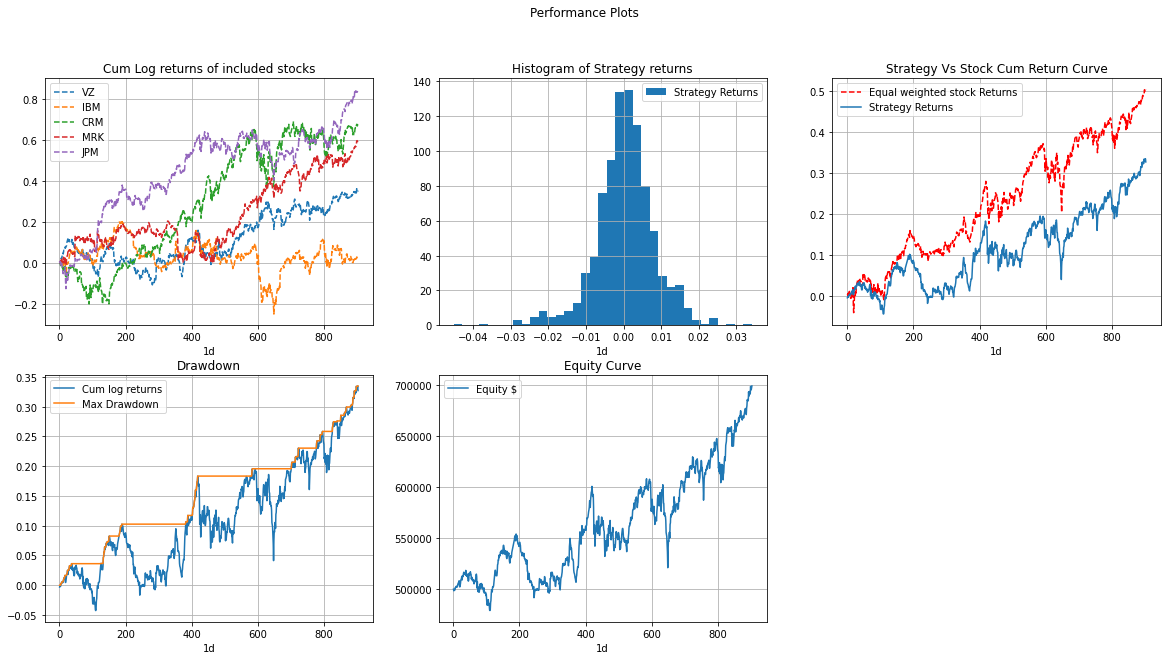

In [ ]:
data = {}

if __name__ == '__main__':
      
  # instantiate an instance of the main class Backtester
  output = ChaikinMFIWithEMAStrategy(tickers, TEST_START, TEST_END, INTERVAL, INITIAL_CAPITAL, 0.00, False)
  output.run_strategy(LookbackWindow=optimal_parameters["Lookback Window"], STWindow=optimal_parameters["Short Term Window"], LTWindow=optimal_parameters["Long Term Window"])

  #get the performance
  output.performance()

  output.performance_plots()


#Benchmark Metrics


We use the DJI as the benchmark for comparing our performance of our strategy.

In [ ]:
stock_data = yf.Ticker('^DJI')
hist_stock = stock_data.history(start = TEST_START, end = TEST_END, interval = INTERVAL)

investment_returns = 100*(((hist_stock["Close"][-1] - hist_stock["Close"][0])/hist_stock["Close"][0]))

bt_data = pd.DataFrame()
bt_data["Close_Price"] = hist_stock["Close"]
bt_data['Stock_Returns'] = np.log(bt_data["Close_Price"] / bt_data["Close_Price"].shift(1)) 


# returns
returns = np.exp(bt_data["Stock_Returns"].sum())-1
print(f'Stock returns: {returns}')

# risk
stock_std_dev = (bt_data["Stock_Returns"].std()) * 100
stock_std_dev = round(stock_std_dev, 2)
print(f'Stock std dev: {stock_std_dev}')

# Sharpe Ratio
avg_returns = bt_data["Stock_Returns"].mean()
std = bt_data["Stock_Returns"].std()
daily_SR = avg_returns / std
annual_SR = daily_SR * (252 ** 0.5)
annual_SR = round(annual_SR, 2)
print(f'Annual SR: {annual_SR}')

# drawdown
bt_data["Gross_Cum_Returns"] = bt_data["Stock_Returns"].cumsum().apply(np.exp) 
bt_data["Cum_Max"] = bt_data["Gross_Cum_Returns"].cummax()
drawdown = bt_data["Cum_Max"] - bt_data["Gross_Cum_Returns"] # it gives the difference between orange and blue
bt_data["drawdown"] = drawdown
drawdown_max = round(bt_data["drawdown"].max(),2)
print(f'Max drawdown: {drawdown_max}')

investment_returns = 100*(((hist_stock["Close"][-1] - hist_stock["Close"][0])/hist_stock["Close"][0]))
print(f'Investment returns: {investment_returns}')
print(f'Returns: {returns}')

Stock returns: 0.6597026715732845
Stock std dev: 0.82
Annual SR: 0.98
Max drawdown: 0.29
Investment returns: 65.97026715732808
Returns: 0.6597026715732845
